# Training 


In [26]:
import numpy as np
import pandas as pd
import os
import sys  
sys.path.append(".")

# deep learning
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


# Setup

In [27]:
# Check version of Pytorch
print(torch. __version__)

1.13.1


In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Data


In [29]:
from data import data_cleaning


## training data images

# choose between big (different angles, 13gb) or small image dataset (only frontal views, 5gb)
all_cars = True # predicate for big or small car-dataset
if all_cars:
    image_dir = "../data/all_cars" # + brand name + year + image_name 
else:
    image_dir = "../data/confirmed_fronts" # + brand name + year + image_name


##  Training data tabular
# data_df = data_cleaning.create_feature_df()
data_df = pd.read_csv("../data/tables/features.csv")
data_df

,Brand_Name,Brand_ID,Model_Name,Model_ID,Bodytype,Launch_Year,Color,Advertiser_ID,Image_ID,file_path
0,Abarth,2,124 Spider,2_1,Convertible,2017,Blue,1,image_1.jpg,Abarth$$124 Spider$$2017$$Blue$$2_1$$1$$image_...
1,Abarth,2,124 Spider,2_1,Convertible,2017,Blue,10,image_11.jpg,Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...
2,Abarth,2,124 Spider,2_1,Convertible,2017,Blue,10,image_16.jpg,Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...
3,Abarth,2,124 Spider,2_1,Convertible,2017,Blue,10,image_18.jpg,Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...
4,Abarth,2,124 Spider,2_1,Convertible,2017,Blue,10,image_2.jpg,Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...
...,...,...,...,...,...,...,...,...,...,...
271318,Zenos,99,E10,99_1,Convertible,2016,Grey,3,image_7.jpg,Zenos$$E10$$2016$$Grey$$99_1$$3$$image_7.jpg
271319,Zenos,99,E10,99_1,Convertible,2016,Red,1,image_0.jpg,Zenos$$E10$$2016$$Red$$99_1$$1$$image_0.jpg
271320,Zenos,99,E10,99_1,Convertible,2016,Red,1,image_3.jpg,Zenos$$E10$$2016$$Red$$99_1$$1$$image_3.jpg
271321,Zenos,99,E10,99_1,Convertible,2016,Red,1,image_4.jpg,Zenos$$E10$$2016$$Red$$99_1$$1$$image_4.jpg


## training data (70%), validation set (10%), test data (20%)

In [30]:
seed = 384
rng = np.random.default_rng(seed)
# TODO: stratify test, train, val by classes (e.g., brand, year, etc.)
# we need to make sure that images of a car model (specified by Model_ID and launch_year) are not distributed over training, validation and test dataset when splitting. 

# subset dataframe by car model (specified by launch_year and model_id) and find unique combinations and then sample accordingly
unique_cars = data_df[["Model_ID", "Launch_Year"]].drop_duplicates()

# draw random indices according to splits from unique cars
rand_nums = rng.uniform(size = len(unique_cars))
msk_train = rand_nums < 0.7 # draws random numbers from uniform distribution, 70%


msk_val_test = ~msk_train # complement

# subset unique cars by indices
msk_val = rand_nums >= 0.9 # 10%

#msk_test = ~msk_val & ~msk_train #  20%
msk_test = (rand_nums > 0.7) & (rand_nums < 0.9)

# test if all datasets only contain unique cars
assert not (np.any(msk_val_test & msk_train))
assert not (np.any(msk_val & msk_test))


# slice unique cars with datamasks 
train_cars_df = unique_cars[msk_train]
test_cars_df = unique_cars[msk_test]
val_cars_df = unique_cars[msk_val]

# check unique cars len is equal to the sum of its sub dfs
assert len(val_cars_df) + len(test_cars_df) + len(train_cars_df) == len(unique_cars)

# complement unique cars per dataset with corresponding rows (launchyear, model id) from features df
# train_df = data.loc[((data['Launch_Year'].isin(train_cars_df['Launch_Year'])) & data['Model_ID'].isin(train_cars_df['Model_ID']))]

# test_df = data.loc[((data['Launch_Year'].isin(test_cars_df['Launch_Year'])) & data['Model_ID'].isin(test_cars_df['Model_ID']))]

# val_df = data.loc[((data['Launch_Year'].isin(val_cars_df['Launch_Year'])) & data['Model_ID'].isin(val_cars_df['Model_ID']))]


#df[df[['a', 'b']].apply(tuple, axis=1).isin([(1,2), (4,3)])]
train_df = data_df[data_df[['Launch_Year', 'Model_ID']].apply(tuple, axis=1).isin(train_cars_df[['Launch_Year', 'Model_ID']].apply(tuple, axis=1))]

val_df = data_df[data_df[['Launch_Year', 'Model_ID']].apply(tuple, axis=1).isin(val_cars_df[['Launch_Year', 'Model_ID']].apply(tuple, axis=1))]

test_df = data_df[data_df[['Launch_Year', 'Model_ID']].apply(tuple, axis=1).isin(test_cars_df[['Launch_Year', 'Model_ID']].apply(tuple, axis=1))]

# check if len of entire data set is equal to sum of test, train and val dataset
assert len(test_df) + len(train_df) + len(val_df) == len(data_df)

In [31]:
train_df["Launch_Year"].unique().size

22

#### Dataset exploration:
- How are car brands distributed over the years in each dataset (val, test, train)?
- How are years distributed over per brand?

In [32]:
# group by year
# count brands

# calculate number of images per year 

def get_images_by_year(data:pd.DataFrame):
    return data.groupby(["Launch_Year"])["file_path"].count()
num_images_by_year_train_df = get_images_by_year(train_df)
num_images_by_year_test_df = get_images_by_year(test_df)
num_images_by_year_val_df = get_images_by_year(val_df)

def plot_dataframes(df:pd.DataFrame,  df_name:str, plot_type:str="bar"):
    df.plot(kind="bar", title=f"Number of Images by Year in {df_name}", xlabel="Years", ylabel="Counts")


### Custom Dataset class

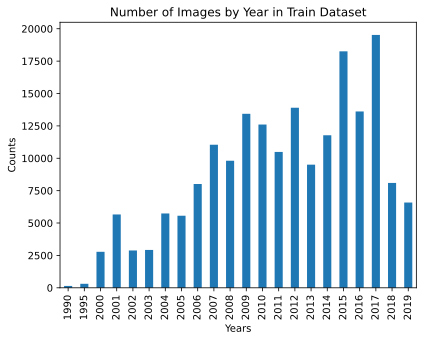

In [33]:
plot_dataframes(num_images_by_year_train_df, df_name="Train Dataset")

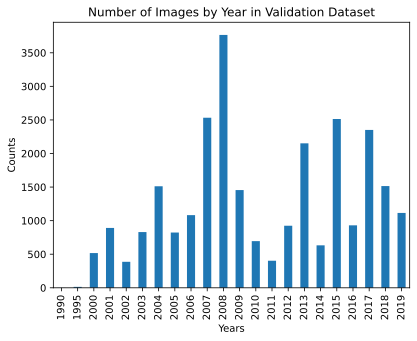

In [34]:
plot_dataframes(num_images_by_year_val_df, df_name="Validation Dataset")

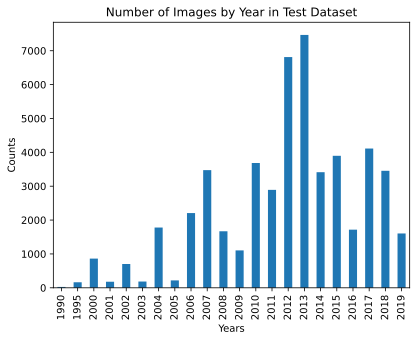

In [35]:
plot_dataframes(num_images_by_year_test_df, df_name="Test Dataset")

In [36]:
# plot stacked number of images by year per dataset 

# combine num_images_by_year_some_dataset dfs to one dataframe
num_images_by_year_all_data = num_images_by_year_train_df.to_frame().join(num_images_by_year_test_df.to_frame(), on="Launch_Year", lsuffix="_train", rsuffix="_test")
num_images_by_year_all_data = num_images_by_year_all_data.join(num_images_by_year_val_df.to_frame(), on="Launch_Year", rsuffix="_val")
num_images_by_year_all_data = num_images_by_year_all_data.rename(columns={"file_path_test":"Num Test Images", "file_path_train":"Num Train Images","file_path":"Num Validation Images"})
num_images_by_year_all_data

,Num Train Images,Num Test Images,Num Validation Images
Launch_Year,,,
1990,144,25,1
1995,307,163,14
2000,2780,862,517
2001,5663,179,891
2002,2884,703,387
2003,2923,185,830
2004,5738,1779,1512
2005,5564,218,823
2006,8013,2207,1082


<AxesSubplot:title={'center':'Number of Images by Launch Year per Dataset'}, xlabel='Launch Year', ylabel='Counts'>

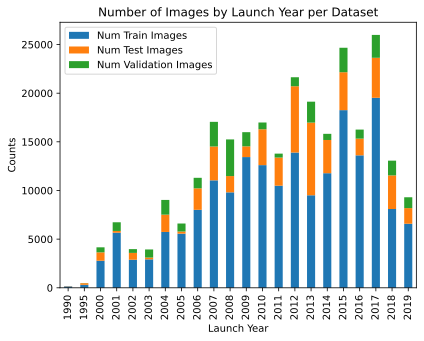

In [37]:
num_images_by_year_all_data.plot.bar(stacked=True, xlabel="Launch Year", ylabel="Counts", title="Number of Images by Launch Year per Dataset")

In [38]:
from typing import Callable
from skimage import io
from data import data_cleaning, year2label_fn, bodytype2label_fn, CarDataset


# set bucket_size for year -> how many years should correspond to one label?
year_bucket_size = 2
min_year = data_df["Launch_Year"].min() # oldest car launch_year in data
max_year = data_df["Launch_Year"].max() # # most recent car launch_year in data
 
car_dataset = CarDataset(
    train_df, 
    lambda year:year2label_fn(year, min_year = min_year, max_year = max_year, year_bucket_size=year_bucket_size)
    )

In [39]:
test_datapoint = car_dataset[10300] # idx 10300 exists in small image dataset

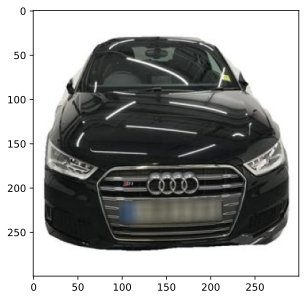

In [40]:
plt.imshow(test_datapoint[0])

In [41]:
year2label_fn(2000, min_year=1990, max_year=2010,year_bucket_size=2)

4

In [42]:
bodytype2label_fn("Car Derived Van")

6

### Data augmentation and transformation:

In [43]:
# resize images to 224x224 (imageNet size)
# normalize image: 
# mean =[0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225] (ImgNet mean and std)
#optional: randomResizedCrop, etc.

# Data agumentation and normalization for training

data_transforms = {
    "train":transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.ColorJitter(),
            transforms.RandomInvert(),
            transforms.RandomPerspective(distortion_scale=0.1, p=0.1),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225]),
        ]
    ),
    "val":transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((224,224)),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225]),

        ]
    )
}

In [44]:
seed_t = 123
torch.manual_seed(seed_t)

# load dataset
# create torch.dataset --> specify transform arguement accordingly

train_set = CarDataset(features=train_df, transform=data_transforms["train"],year2label_fn=lambda year:year2label_fn(year, min_year = min_year, max_year = max_year, year_bucket_size=year_bucket_size))
test_set = CarDataset(features=test_df, transform=data_transforms["val"],year2label_fn=lambda year:year2label_fn(year, min_year = min_year, max_year = max_year, year_bucket_size=year_bucket_size))
val_set = CarDataset(features=val_df, transform=data_transforms["val"],year2label_fn=lambda year:year2label_fn(year, min_year = min_year, max_year = max_year, year_bucket_size=year_bucket_size))


# data loaders for all train, test, val datasets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), shuffle=True)

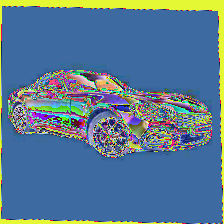

In [45]:
test_point_transf = train_set[12]
post_transf = torchvision.transforms.functional.to_pil_image(test_point_transf[0])
post_transf

In [46]:
test_point_transf[0].shape

torch.Size([3, 224, 224])

In [47]:
train_df.columns

Index(['Brand_Name', 'Brand_ID', 'Model_Name', 'Model_ID', 'Bodytype',
       'Launch_Year', 'Color', 'Advertiser_ID', 'Image_ID', 'file_path'],
      dtype='object')

In [48]:
# dataloader dic

dataloader_dic = dict({"train":train_loader, "val":val_loader, "test":test_loader})

#  a dataloader has  the following attributes: 
# image, bodytype, model_id, launch_year, self.bodytype2label_fn(bodytype), self.year2label_fn(year=launch_year, year_bucket_size = self.year_bucket_size)

## Model

In [49]:
import torchvision.models as models

model = models.resnet18(pretrained=True)

# freeze paramaters of pretrained model:
for param in model.parameters():
    param.requires_grad = False

model

/opt/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Replace final layer of Resnet18 with a new fully connected layer with number of features equal to the number of output classes and initialize with random weights.


In [50]:
# compute number of classes of final layer which depends on year_bucket size and year_range
year_range = max_year - min_year
num_year_classes = 1 +  (year_range // year_bucket_size) # floor division

in_features_final_layer = 512 # in-features of final layer of resnet18
out_features_final_layer = num_year_classes # the number of classes, year categories

# add custom final layer to resnet18
model.add_module(
    "fc",
    nn.Linear(
        in_features = in_features_final_layer,
        out_features = out_features_final_layer
    ),
)

# apply softmax to final layers' outputs
model.add_module("sm", nn.Softmax(dim=0))

In [51]:
num_year_classes

15

In [52]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## define loss function, optimizer and learning rate

In [53]:
learning_rate = 5e-4

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.fc.parameters(), lr=learning_rate)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##  training


In [54]:
# training loop 

def train_model(model, criterion, optimizer, num_epochs=2, phase="train"):
    for epoch in range(num_epochs):
        # print epoch
        print(f"Epoch {epoch} of {num_epochs -1}")
        print("--" * 10)

        # each epoch has a training and validation phase
        if phase == "train":
            model.train() # set model to training mode

        else:
            model.eval() # set model to evaluation mode

        # for tracking performance
        running_loss = 0.0
        running_corrects = 0.0

        # iterate over data
        ## loop over inputs and labels in dataloaders (in dict form for training/test phase)

        #  a dataloader has  the following attributes: 
        # image, bodytype, model_id, launch_year, self.bodytype2label_fn(bodytype), self.year2label_fn(year=launch_year, year_bucket_size = self.year_bucket_size)

        ## inputs and labels to device
        for inputs, _, _, _, _,year_labels in dataloader_dic[phase]:
            print(year_labels)
            inputs = inputs.to(device)
            year_labels = year_labels.to(device)
    

            ## zero the parameters of the gradient
            optimizer.zero_grad()

            # forward pass
            # track history only if in train mode
            with torch.set_grad_enabled(phase=="train"):
                outputs = model(inputs)
                _, predictions = torch.max(outputs,1) # dim = 1
                loss = criterion(outputs, year_labels)
                # backward + optimize only when in training phase
                if phase == "train":
                    loss.backward()
                    optimizer.step()

            # Statistics:
            running_loss  += loss.item() + inputs.size(0) # dim=0
            running_corrects += torch.sum(predictions == year_labels.data)
            
        epoch_loss = (running_loss / data_set_dic[phase])
        epoch_acc = running_corrects.double() / data_set_dic[phase] #  .double() is equivalent to self.to(torch.float64)

        print(f"{phase}:, Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}")
        return epoch_loss, epoch_acc

    

In [55]:
train_model(model, criterion=criterion, optimizer=optimizer)

Epoch 0 of 1
--------------------
tensor([ 5,  8, 13, 14, 13, 13,  7, 14,  8, 12, 12, 11, 12,  9, 13, 12,  9, 10,
         8, 13, 10, 11,  8, 14,  6,  9,  8,  9, 10, 14, 12, 11])
tensor([ 9, 12, 12, 13, 14,  2, 14, 12, 13,  8, 13,  7,  6, 13, 10, 12, 13,  9,
        10, 11, 12,  9, 12,  8, 13, 11,  5, 10, 13,  9,  8, 13])
tensor([ 6,  9,  8, 10, 14, 10,  9,  8,  7, 10, 14, 11,  5, 14, 13, 10, 12,  7,
        12, 10, 12,  9,  7, 11,  9,  5, 12, 13, 10, 11,  9,  9])
tensor([ 8,  6, 12, 12, 11, 12,  5, 11,  9,  9, 12, 10, 13,  7, 10, 11, 12, 12,
        13,  5, 11, 12,  7, 12, 13, 11,  5, 10,  9,  9, 14, 13])
tensor([ 7,  6, 12,  9,  8,  9, 10,  8, 13, 11, 11, 12, 13, 11, 13,  7, 11,  9,
        11, 12, 12, 14,  7, 14, 12,  8,  9, 12, 13,  6,  5,  5])
tensor([13,  8, 11,  8, 13,  8, 10,  6, 13,  9, 10, 10, 10, 12, 10,  5,  9,  8,
         7,  7, 11, 13, 10, 12, 13,  8, 13, 10, 12, 10, 12, 10])
tensor([13,  7,  5,  8, 10,  9, 11, 14,  9, 12, 12, 12,  9, 12, 13, 11, 14,  8,
        12, 12, 

KeyboardInterrupt: 

##  evaluation